<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/test_preprocessing/mv_chronos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-le8ajm9n
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-le8ajm9n
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 28e7b3281f68d1493a6290b3aa32902128ad2157
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Variance: [  4.5395927   7.8084564   8.279922    6.9867454  10.776463   25.127079
  31.449244   46.423977   39.33399    47.254654   63.14987    55.606384
  62.41349    69.377754   85.36278   104.81877   121.67946   125.16374
 130.01315   144.96097   157.49748   159.47324   172.93927   184.47458
 206.63358   215.07507   229.10686   273.26776   293.88666   325.713    ]


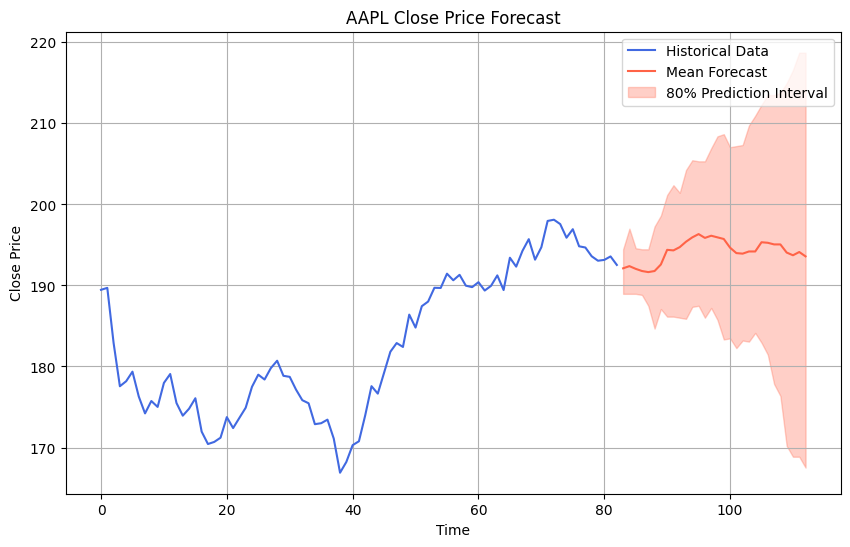

In [3]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cpu for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)

#Colonna 'Close' come serie temporale
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

#Forecasting
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

#Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

plt.figure(figsize=(10, 6))
plt.plot(close_prices, color="royalblue", label="Historical Data")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

### Pre-processing (from multivariate to univariate) using simple methods

Weighted Mean (Open, High, Low, Close)
Variance: [ 387.398    536.2192   625.6955   804.7882   953.84045  825.9254
  978.5584  1039.0046  1174.649   1176.5692  1653.675   1972.8486
 2213.4082  2650.1216  2902.4233  3359.8743  3312.845   4365.923
 4575.758   4183.389   3869.052   4594.2383  5593.992   5645.203
 5350.7666  4527.435   3500.5723  2691.5103  2264.4946  2220.2808 ]


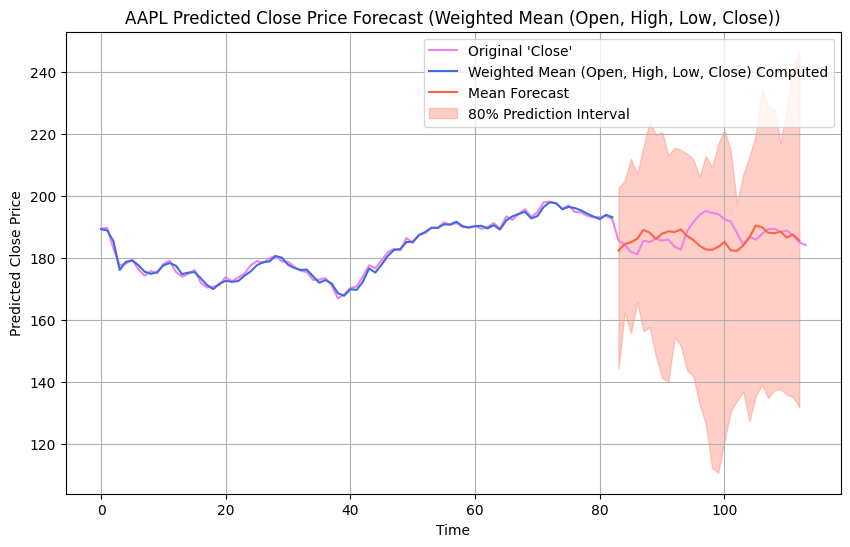

Arithmetic Mean
Variance: [  1.3049151   2.1300044   2.6187732   4.641132    9.667891   13.273163
  13.860582   14.147573   25.936443   32.622322   41.16012    59.45553
  88.71471    99.90717   118.072525  111.566     121.23384   140.42613
 127.3323    129.16183   131.11693   132.45766   135.70871   141.08974
 146.52455   155.30896   169.96777   179.6312    176.7479    188.9224   ]


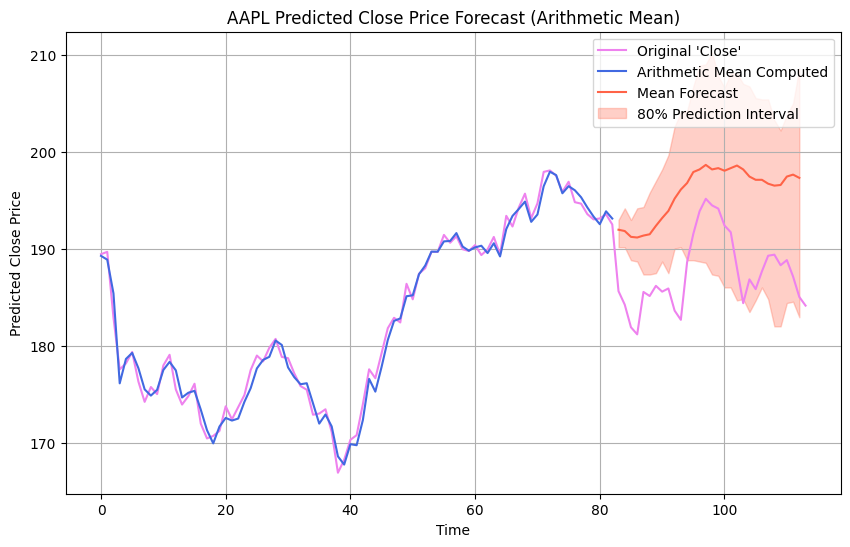

VWAP (Volume Weighted Average Price)
Variance: [335359.3  335853.2  337305.84 338195.75 337285.56 337944.25 339111.56
 343879.03 344364.06 344560.84 344823.56 345805.28 346189.6  346428.9
 346277.22 347451.75 347160.94 347686.94 347273.2  347970.1  348809.97
 349291.1  349444.06 349476.88 348732.75 347684.94 345765.34 341150.
 340620.88 340555.88]


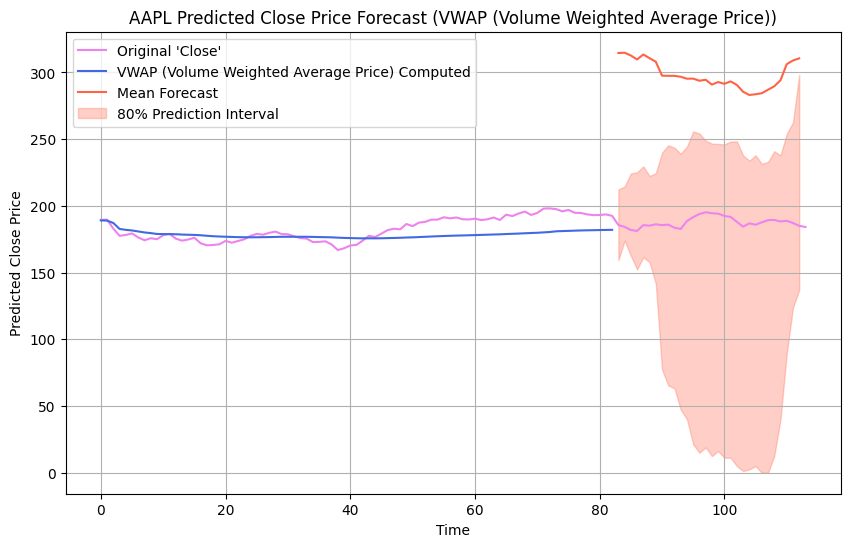

In [75]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

# Imposta il seed per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Scarica i dati da Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False) # data to trasform from multivariate to univariate
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False) # data to predict with chronos
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values]) # extract Close column

# Soluzione 1: Media pesata tra Open, High, Low e Close
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Soluzione 2: Media aritmetica
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Soluzione 3: Analisi basata sul volume
aapl_vwap = (data['Volume'] * (data['High'] + data['Low']) / 2).cumsum() / data['Volume'].cumsum()

# Modello Chronos
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

# Itera sui metodi per il calcolo dei prezzi di chiusura
methods = {
    "Weighted Mean (Open, High, Low, Close)": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "VWAP (Volume Weighted Average Price)": aapl_vwap
}

for title, close_prices in methods.items():
    # Step 1: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=30
    )

    # Step 2: Visualizzazione
    forecast_index = range(len(close_prices), len(close_prices) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")
    plt.plot(close_prices.values, color="royalblue", label=f"{title} Computed")
    plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.show()

Soluzione 4: PCA

Explained Variance Ratio of the first component: 0.8082937960477582
Variance: [ 0.35921618  0.5208636   1.185405    2.0834398   2.9230995   4.472213
  4.849388    8.347236   14.238367   15.087004   15.464193   13.519954
 13.201146   13.160731   13.5199375  14.368578   14.417978   13.757919
 16.681025   18.405262   20.277662   23.326488   26.150822   30.26382
 33.133064   34.569927   35.6341     33.635963   32.58077    28.360012  ]


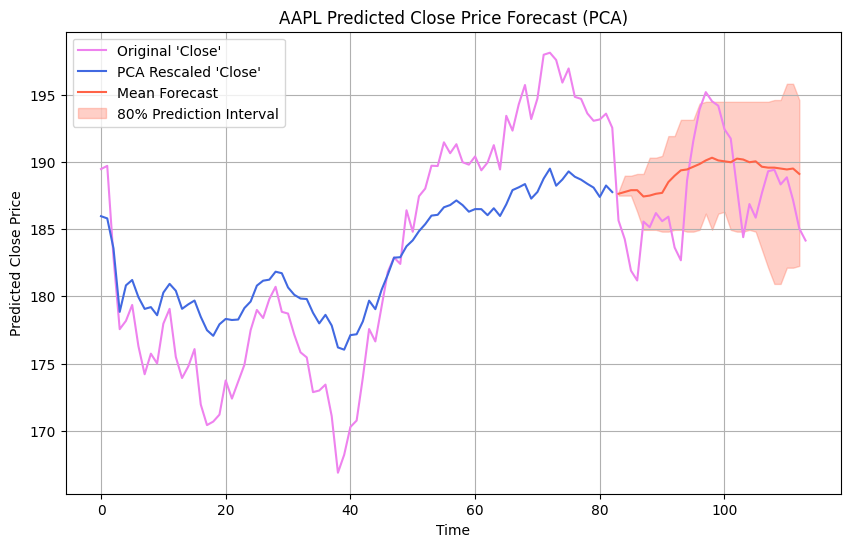

In [77]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

# Imposta il seed per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Scarica i dati da Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

# Standardizza i dati
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Applica PCA
pca = PCA(n_components=1)
aapl_pca = pca.fit_transform(scaled_data)

# Debug PCA explained variance
explained_variance = pca.explained_variance_ratio_[0]
print(f"Explained Variance Ratio of the first component: {explained_variance}")

# Rescale PCA output to a meaningful range
aapl_pca_rescaled = aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

# Serie temporale univariata
close_prices = aapl_pca_series.values  # Usa la serie calcolata da PCA

# Modello Chronos
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

# Forecasting con Chronos
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

# Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

plt.figure(figsize=(10, 6))
plt.plot(all_close_values, color="violet", label="Original 'Close'")
plt.plot(close_prices, color="royalblue", label="PCA Rescaled 'Close'")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Predicted Close Price Forecast (PCA)")
plt.xlabel("Time")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid()
plt.show()


### Pre-processing (from multivariate to univariate) using ML methods

(83, 4)
(83, 1)
Variance: [ 386.1115   534.43835  623.6177   802.11584  950.67303  823.1825
  975.3084  1035.5541  1170.748   1172.6619  1648.1829  1966.2969
 2206.0579  2641.3203  2892.7847  3348.7163  3301.843   4351.4233
 4560.562   4169.4956  3856.2026  4578.9805  5575.4146  5626.4546
 5332.997   4512.399   3488.9468  2682.5715  2256.974   2212.9072 ]


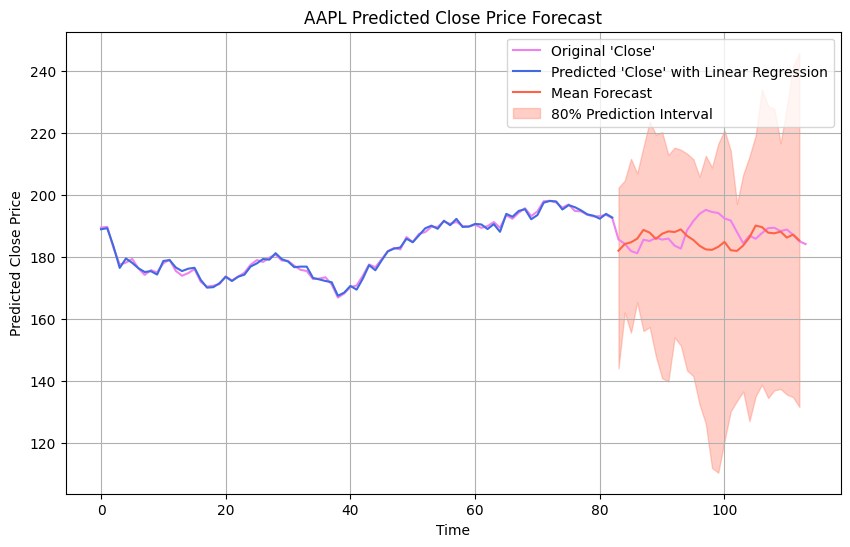

In [42]:
# Soluzione 1: Modello di regressione lineare

import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Imposta il seed per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Scarica i dati da Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
close_to_predict = data_to_predict['Close']

# Step 1: Creare una serie temporale univariata basata su una regressione lineare
# Variabili indipendenti
X = data[['Open', 'High', 'Low', 'Volume']].values
# Variabile dipendente
y = data['Close'].values

# Modello di regressione lineare
model = LinearRegression()
model.fit(X, y)
print(X.shape)

# Previsione dei valori di Close
predicted_close = model.predict(X)
print(predicted_close.shape)

# Step 2: Modello Chronos per il forecasting
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

# Prepara i dati come serie temporale univariata
close_prices = predicted_close  # Usa la serie calcolata

# Step 3: Forecasting con Chronos
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

# Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

plt.figure(figsize=(10, 6))
plt.plot(all_close_values, color="violet", label="Original 'Close'")
plt.plot(close_prices, color="royalblue", label="Predicted 'Close' with Linear Regression")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Predicted Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid()
plt.show()
